# Ticket 3: Preprocesamiento de Señal EEG (Filtro Básico)

Este notebook muestra un ejemplo de cómo limpiar el ruido de una señal EEG aplicando técnicas de filtrado básico. Se utilizan dos filtros:

- **Filtro pasa-bajos:** Para atenuar las componentes de alta frecuencia no deseadas.
- **Filtro notch:** Para eliminar el ruido de red eléctrica (50 o 60 Hz).

Se cargan los datos del archivo `v1p.mat` (que contiene 19 canales de EEG según el estándar 10-20, muestreados a 128 Hz) y se aplican estos filtros al canal **Fz**. Se presentan gráficos comparativos de la señal original y la señal filtrada.

**Nota:** Los parámetros de los filtros (frecuencia de corte, orden, frecuencia notch, factor de calidad) pueden ajustarse según sea necesario.

In [1]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, iirnotch

# Configurar Matplotlib para gráficos en línea (para Jupyter/Colab)
%matplotlib inline

print('Entorno configurado y librerías importadas correctamente.')

Entorno configurado y librerías importadas correctamente.


In [2]:
# Cargar el archivo v1p.mat
mat_data = loadmat('v1p.mat', squeeze_me=True)

# Verificar las llaves disponibles en el archivo
print('Llaves en el archivo .mat:', mat_data.keys())

# Extraer la variable 'v1p'
data_array = mat_data['v1p']

print('Forma del array:', data_array.shape)
print('Tipo de datos:', data_array.dtype)

Llaves en el archivo .mat: dict_keys(['__header__', '__version__', '__globals__', 'v1p'])
Forma del array: (12258, 19)
Tipo de datos: int16


In [3]:
# Convertir la matriz en un DataFrame de pandas
df = pd.DataFrame(data_array)

# Asignar nombres de columnas de acuerdo con el estándar 10-20
channel_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']

if df.shape[1] == len(channel_names):
    df.columns = channel_names
else:
    print('Advertencia: El número de columnas en el dataset no coincide con el número de canales esperados.')

print('Primeras 5 filas del DataFrame:')
print(df.head())

Primeras 5 filas del DataFrame:
    Fz   Cz   Pz   C3   T3   C4   T4  Fp1  Fp2    F3   F4   F7   F8   P3   P4  \
0   85 -407  200  191  420  457  310  310   16  1009  531  126  457  200  457   
1 -266  -55  -20  367  163  384  -20  310  494  1193  494  236  236  310  200   
2  -90  -19  126  437  420  568  347  457 -131  1156  384  384  494  384  494   
3  -90 -160  163  473  384  494  310  384  457  1340  494  420  310  420  273   
4 -301 -336  -20  473  200  531   89  420  200  1156  310  494  273  457  236   

    T5   T6   O1   O2  
0  384  -90  473  121  
1  457 -195  543   15  
2  531  -19  613  261  
3  531  -90  437  -19  
4  568 -160  578  121  


## Definición de Funciones de Filtrado

Se definen dos funciones principales:

- **Filtro pasa-bajos:** Utiliza un filtro Butterworth para atenuar las altas frecuencias.
- **Filtro notch:** Emplea un filtro notch (iirnotch) para eliminar el ruido de la red eléctrica (50 o 60 Hz).

Ambos filtros se aplican mediante `filtfilt` para evitar desfases en la señal.

In [4]:
def butter_lowpass(cutoff, fs, order=5):
    """Calcula los coeficientes de un filtro Butterworth pasa-bajos."""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    """Aplica un filtro pasa-bajos a la señal."""
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, notch_freq, fs, quality_factor=30):
    """Aplica un filtro notch para eliminar el ruido a una frecuencia específica (ej. 50 Hz)."""
    nyq = 0.5 * fs
    norm_notch = notch_freq / nyq
    b, a = iirnotch(norm_notch, quality_factor)
    y = filtfilt(b, a, data)
    return y

# Parámetros de filtrado
fs = 128              # Frecuencia de muestreo en Hz
lowpass_cutoff = 40   # Frecuencia de corte para el filtro pasa-bajos (Hz)
notch_freq = 50       # Frecuencia para el filtro notch (50 o 60 Hz, según corresponda)
order = 4             # Orden del filtro pasa-bajos
quality_factor = 30   # Factor de calidad para el filtro notch

print('Funciones de filtrado definidas. Parámetros de filtrado:')
print(f'Filtro pasa-bajos: corte = {lowpass_cutoff} Hz, orden = {order}')
print(f'Filtro notch: frecuencia = {notch_freq} Hz, Q = {quality_factor}')

Funciones de filtrado definidas. Parámetros de filtrado:
Filtro pasa-bajos: corte = 40 Hz, orden = 4
Filtro notch: frecuencia = 50 Hz, Q = 30


## Aplicación de los Filtros a una Señal (Canal Fz)

Se aplica primero el filtro pasa-bajos y luego el filtro notch a la señal del canal **Fz**. Se genera un gráfico comparativo que muestra la señal original y la señal filtrada.

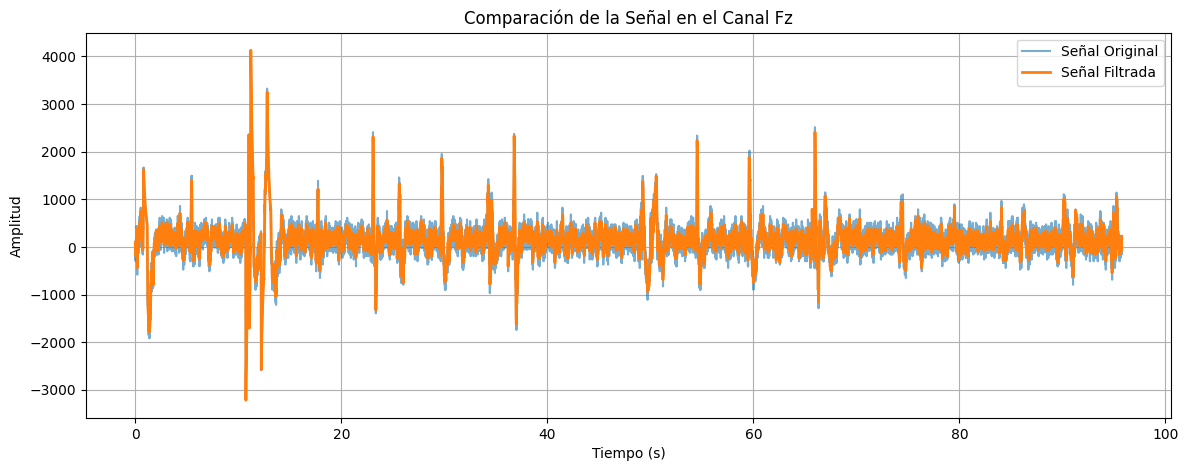

In [5]:
# Crear el eje temporal (asumiendo que cada fila es una muestra consecutiva)
num_samples = df.shape[0]
time_axis = np.arange(num_samples) / fs  # en segundos

# Seleccionar el canal a filtrar (por ejemplo, Fz)
channel = 'Fz'
original_signal = df[channel].values

# Aplicar el filtro pasa-bajos
filtered_signal_lp = butter_lowpass_filter(original_signal, lowpass_cutoff, fs, order=order)

# Aplicar el filtro notch
filtered_signal = notch_filter(filtered_signal_lp, notch_freq, fs, quality_factor=quality_factor)

# Graficar la señal original y la señal filtrada
plt.figure(figsize=(14, 5))
plt.plot(time_axis, original_signal, label='Señal Original', alpha=0.6)
plt.plot(time_axis, filtered_signal, label='Señal Filtrada', linewidth=2)
plt.title(f'Comparación de la Señal en el Canal {channel}')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

## Detección y Marcado de Artefactos (Opcional)

Si bien la detección automática de artefactos como parpadeos o movimientos requiere métodos más avanzados (por ejemplo, basados en umbrales o técnicas de Machine Learning), a modo de ejemplo se puede detectar artefactos evidentes marcando aquellos segmentos donde la amplitud exceda un umbral definido. En este ejemplo, se muestra cómo marcar dichos puntos en la señal filtrada.

```python
# Ejemplo simple: marcar puntos donde la amplitud exceda un umbral
umbral = np.mean(filtered_signal) + 3*np.std(filtered_signal)
artefactos = np.where(np.abs(filtered_signal) > umbral)[0]

# Graficar la señal filtrada y marcar los artefactos
plt.figure(figsize=(14, 5))
plt.plot(time_axis, filtered_signal, label='Señal Filtrada', linewidth=2)
plt.scatter(time_axis[artefactos], filtered_signal[artefactos], color='red', marker='o', label='Artefactos')
plt.title(f'Señal Filtrada con Artefactos Marcados (umbral = {umbral:.2f})')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()
```

Este bloque es opcional y puede ajustarse en función de la naturaleza de los artefactos en el dataset.

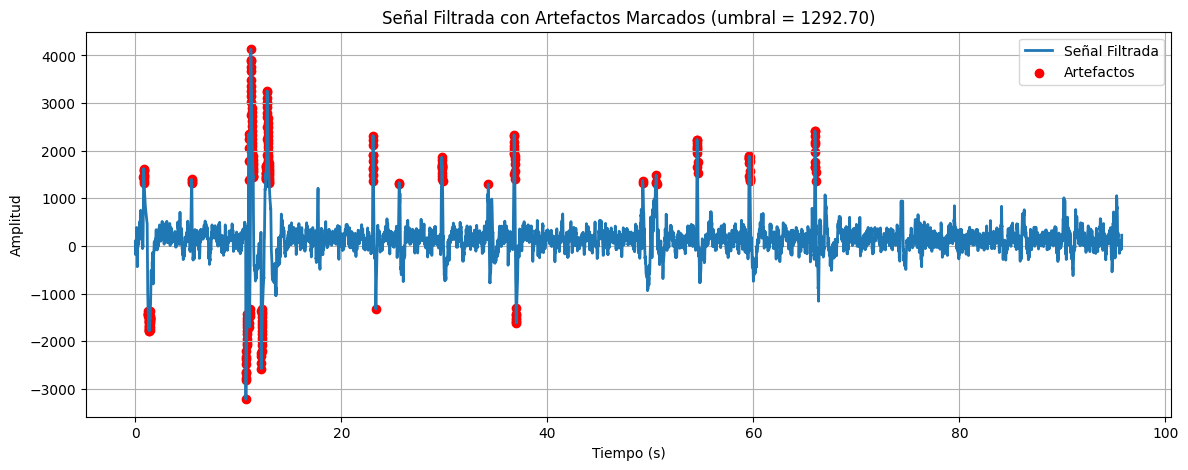

In [6]:
# Ejemplo opcional: detección simple de artefactos en la señal filtrada
umbral = np.mean(filtered_signal) + 3 * np.std(filtered_signal)
artefactos = np.where(np.abs(filtered_signal) > umbral)[0]

plt.figure(figsize=(14, 5))
plt.plot(time_axis, filtered_signal, label='Señal Filtrada', linewidth=2)
plt.scatter(time_axis[artefactos], filtered_signal[artefactos], color='red', marker='o', label='Artefactos')
plt.title(f'Señal Filtrada con Artefactos Marcados (umbral = {umbral:.2f})')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

## Conclusiones e Interpretación

En este notebook se ha demostrado cómo aplicar un filtrado básico a una señal EEG:

- Se utilizó un **filtro pasa-bajos** para eliminar las altas frecuencias (ruido no deseado) con una frecuencia de corte ajustable.
- Se aplicó un **filtro notch** para eliminar la interferencia a 50 Hz (o 60 Hz, según se requiera) típica del ruido de red eléctrica.

Los gráficos comparativos muestran claramente cómo se atenua el ruido sin distorsionar excesivamente los componentes principales de la señal. Además, se incluye un ejemplo opcional de detección de artefactos mediante umbralización.

**Consejo Profesional:**

El preprocesamiento adecuado de la señal EEG es fundamental para obtener modelos robustos en inteligencia artificial. Ajusta cuidadosamente los parámetros del filtro para equilibrar la eliminación de ruido y la preservación de la señal de interés. Documenta cada ajuste y evalúa visualmente los resultados para asegurar la calidad del procesamiento. ¡Sigue profundizando en técnicas avanzadas para optimizar cada etapa del análisis!